In [ ]:

!pip install -q qiskit
!pip install -q qiskit-Aer
!pip install -q qiskit-algorithms
!pip install -q qiskit-optimization
!pip install -q qiskit-ibm-runtime
!pip install -q pylatexenc

In [9]:
import tensorflow as tf

# Check if GPU is available
if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")


GPU is not available


In [36]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import time

from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.circuit.library import QAOAAnsatz, TwoLocal
from qiskit_optimization.applications import Tsp
from qiskit_algorithms.minimum_eigensolvers import SamplingVQE
from qiskit_algorithms.optimizers import SPSA, COBYLA, L_BFGS_B, POWELL
# from qiskit_algorithms.utils import algorithm_globals
from qiskit.primitives import Sampler
from qiskit_ibm_runtime import SamplerV2
from qiskit.quantum_info import Operator, SparsePauliOp
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.converters import QuadraticProgramToQubo
from scipy.optimize import minimize


In [11]:
import pandas as pd

# Read the Excel file
df = pd.read_excel('distance_matrix.xlsx', header=None)

# Convert the DataFrame to a NumPy array
distance_matrix = df.to_numpy()
print(distance_matrix)

[[ 0 10 15 20]
 [10  0 35 25]
 [15 35  0 30]
 [20 35 30  0]]


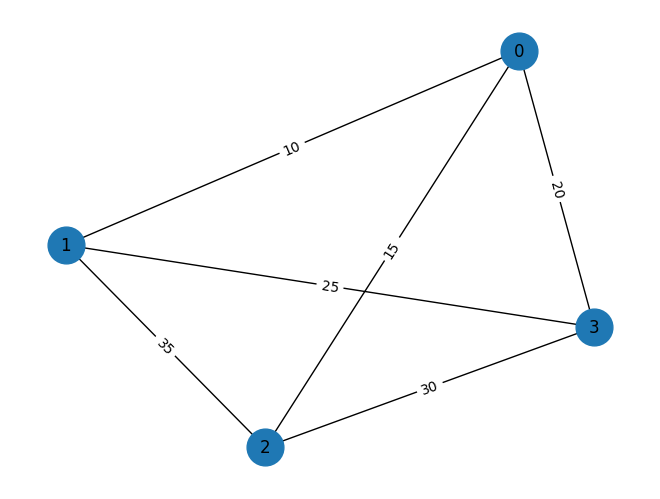

TSP Instance:
Number of nodes: 4
Number of edges: 6


In [12]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
# from qiskit.optimization.applications.ising import Tsp

# Read the Excel file
df = pd.read_excel('distance_matrix.xlsx', header=None)

# Convert the DataFrame to a NumPy array
distance_matrix = df.to_numpy()

# Create a NetworkX graph from the adjacency matrix
G = nx.Graph()

# Add nodes
num_nodes = distance_matrix.shape[0]
for i in range(num_nodes):
    G.add_node(i)

# Add edges with weights
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        G.add_edge(i, j, weight=distance_matrix[i, j])

# Create a TSP instance using the graph
tsp_instance = Tsp(graph=G)

# Draw the graph
pos = nx.spring_layout(G)  # Layout for better visualization
nx.draw(G, pos, with_labels=True, node_size=700, font_size=12)

# Draw edge labels
edge_labels = {(i, j): G[i][j]['weight'] for i, j in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.show()

# Print the TSP instance details
print("TSP Instance:")
print("Number of nodes:", tsp_instance.graph.number_of_nodes())
print("Number of edges:", tsp_instance.graph.number_of_edges())


In [13]:
qp = tsp_instance.to_quadratic_program()
print(qp.prettyprint())

Problem name: TSP

Minimize
  10*x_0_0*x_1_1 + 10*x_0_0*x_1_3 + 15*x_0_0*x_2_1 + 15*x_0_0*x_2_3
  + 20*x_0_0*x_3_1 + 20*x_0_0*x_3_3 + 10*x_0_1*x_1_0 + 10*x_0_1*x_1_2
  + 15*x_0_1*x_2_0 + 15*x_0_1*x_2_2 + 20*x_0_1*x_3_0 + 20*x_0_1*x_3_2
  + 10*x_0_2*x_1_1 + 10*x_0_2*x_1_3 + 15*x_0_2*x_2_1 + 15*x_0_2*x_2_3
  + 20*x_0_2*x_3_1 + 20*x_0_2*x_3_3 + 10*x_0_3*x_1_0 + 10*x_0_3*x_1_2
  + 15*x_0_3*x_2_0 + 15*x_0_3*x_2_2 + 20*x_0_3*x_3_0 + 20*x_0_3*x_3_2
  + 35*x_1_0*x_2_1 + 35*x_1_0*x_2_3 + 25*x_1_0*x_3_1 + 25*x_1_0*x_3_3
  + 35*x_1_1*x_2_0 + 35*x_1_1*x_2_2 + 25*x_1_1*x_3_0 + 25*x_1_1*x_3_2
  + 35*x_1_2*x_2_1 + 35*x_1_2*x_2_3 + 25*x_1_2*x_3_1 + 25*x_1_2*x_3_3
  + 35*x_1_3*x_2_0 + 35*x_1_3*x_2_2 + 25*x_1_3*x_3_0 + 25*x_1_3*x_3_2
  + 30*x_2_0*x_3_1 + 30*x_2_0*x_3_3 + 30*x_2_1*x_3_0 + 30*x_2_1*x_3_2
  + 30*x_2_2*x_3_1 + 30*x_2_2*x_3_3 + 30*x_2_3*x_3_0 + 30*x_2_3*x_3_2

Subject to
  Linear constraints (8)
    x_0_0 + x_0_1 + x_0_2 + x_0_3 == 1  'c0'
    x_1_0 + x_1_1 + x_1_2 + x_1_3 == 1  'c1'
    x_2

In [14]:
qp2qubo = QuadraticProgramToQubo()
qubo = qp2qubo.convert(qp)
hamiltonian, offset = qubo.to_ising()
print(qubo)
print("====")
print(hamiltonian)
print(hamiltonian.num_qubits)

minimize 2162*x_0_0^2 + 2162*x_0_0*x_0_1 + 2162*x_0_0*x_0_2 + 2162*x_0_0*x_0_3 + 2162*x_0_0*x_1_0 + 10*x_0_0*x_1_1 + 10*x_0_0*x_1_3 + 2162*x_0_0*x_2_0 + 15*x_0_0*x_2_1 + 15*x_0_0*x_2_3 + 2162*x_0_0*x_3_0 + 20*x_0_0*x_3_1 + 20*x_0_0*x_3_3 + 2162*x_0_1^2 + 2162*x_0_1*x_0_2 + 2162*x_0_1*x_0_3 + 10*x_0_1*x_1_0 + 2162*x_0_1*x_1_1 + 10*x_0_1*x_1_2 + 15*x_0_1*x_2_0 + 2162*x_0_1*x_2_1 + 15*x_0_1*x_2_2 + 20*x_0_1*x_3_0 + 2162*x_0_1*x_3_1 + 20*x_0_1*x_3_2 + 2162*x_0_2^2 + 2162*x_0_2*x_0_3 + 10*x_0_2*x_1_1 + 2162*x_0_2*x_1_2 + 10*x_0_2*x_1_3 + 15*x_0_2*x_2_1 + 2162*x_0_2*x_2_2 + 15*x_0_2*x_2_3 + 20*x_0_2*x_3_1 + 2162*x_0_2*x_3_2 + 20*x_0_2*x_3_3 + 2162*x_0_3^2 + 10*x_0_3*x_1_0 + 10*x_0_3*x_1_2 + 2162*x_0_3*x_1_3 + 15*x_0_3*x_2_0 + 15*x_0_3*x_2_2 + 2162*x_0_3*x_2_3 + 20*x_0_3*x_3_0 + 20*x_0_3*x_3_2 + 2162*x_0_3*x_3_3 + 2162*x_1_0^2 + 2162*x_1_0*x_1_1 + 2162*x_1_0*x_1_2 + 2162*x_1_0*x_1_3 + 2162*x_1_0*x_2_0 + 35*x_1_0*x_2_1 + 35*x_1_0*x_2_3 + 2162*x_1_0*x_3_0 + 25*x_1_0*x_3_1 + 25*x_1_0*x_3_3 + 216

## Run TSP on Simulator

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


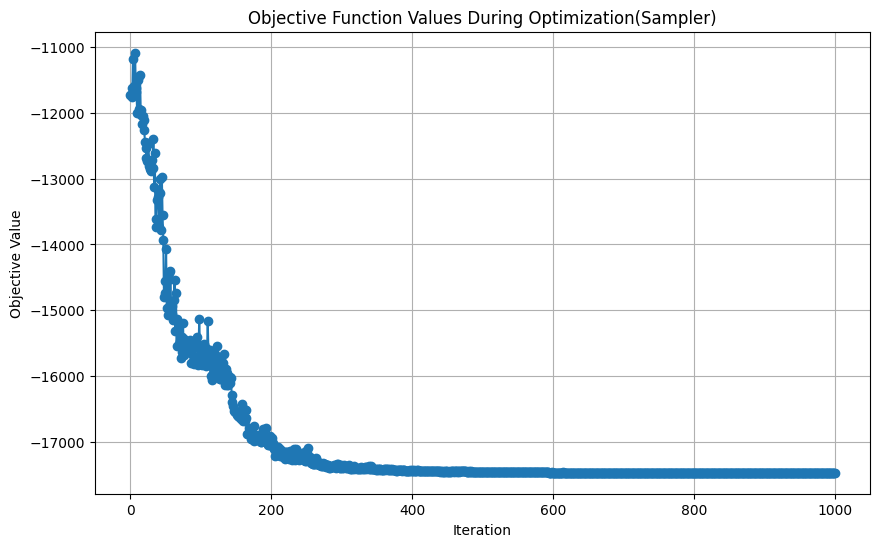

Sampling time 1238.569510936737


In [37]:
counts = []
values = []
def samplevqe_callback(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)
    # print(f"Current parameters: {parameters}, Objective value: {mean}")

optimizer = COBYLA(maxiter=1000)

# backend = AerSimulator(method="matrix_product_state")

sampler = Sampler()

p = 1

# ansatz = QAOAAnsatz(hamiltonian, reps=p)

ansatz = TwoLocal(hamiltonian.num_qubits, "ry", "rzz", reps=p, entanglement="linear")
init_point = np.random.random(ansatz.num_parameters)

start_time = time.time()
sampling_vqe = SamplingVQE(sampler, ansatz, optimizer, initial_point=init_point, callback=samplevqe_callback)
result_samp = sampling_vqe.compute_minimum_eigenvalue(hamiltonian)
end_time = time.time()

plt.figure(figsize=(10, 6))
plt.plot(values, marker="o")
plt.title("Objective Function Values During Optimization(Sampler)")
plt.xlabel("Iteration")
plt.ylabel("Objective Value")
plt.grid(True)
plt.show()
print("Sampling time", end_time-start_time)

In [38]:
def draw_tsp_solution(G, order, colors, pos):
    G2 = nx.DiGraph()
    G2.add_nodes_from(G)
    n = len(order)
    for i in range(n):
        j = (i + 1) % n
        G2.add_edge(order[i], order[j], weight=G[order[i]][order[j]]["weight"])
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(
        G2, node_color=colors, edge_color="b", node_size=600, alpha=0.8, ax=default_axes, pos=pos
    )
    edge_labels = nx.get_edge_attributes(G2, "weight")
    nx.draw_networkx_edge_labels(G2, pos, font_color="b", edge_labels=edge_labels)


In [39]:
def draw_graph(G, colors, pos):
    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, node_color=colors, with_labels=True, node_size=500, font_color='white', font_weight='bold', edge_color='gray')
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.show()

feasible: True
solution: [1, 2, 0, 3]
solution objective: 105.0


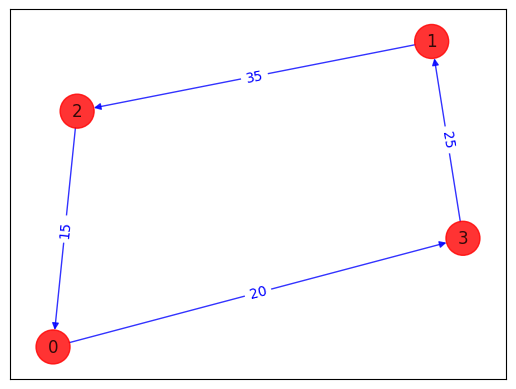

In [40]:
x = tsp_instance.sample_most_likely(result_samp.eigenstate)
print("feasible:", qubo.is_feasible(x))
z = tsp_instance.interpret(x)
print("solution:", z)
print("solution objective:", tsp_instance.tsp_value(z, distance_matrix))
colors = ["r" for node in tsp_instance.graph.nodes]
pos = nx.spring_layout(tsp_instance.graph)
draw_tsp_solution(tsp_instance.graph, z, colors, pos)

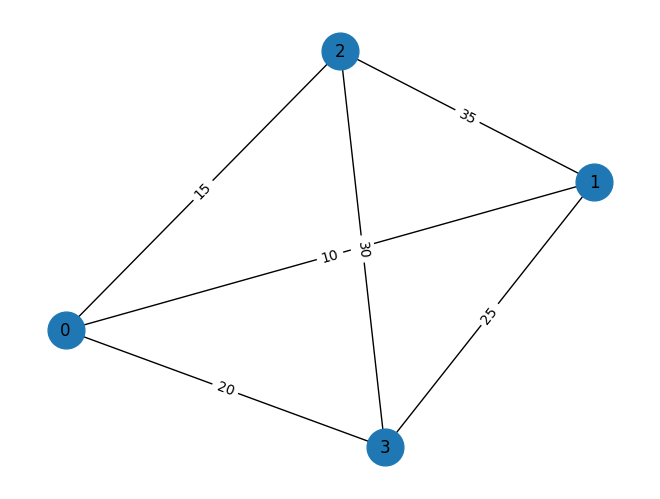

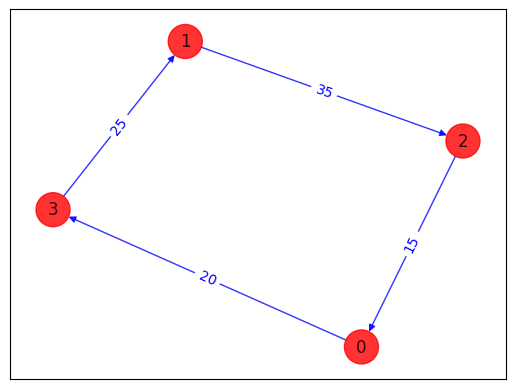

In [41]:
#Problem Network
pos = nx.spring_layout(G)  # Layout for better visualization
nx.draw(G, pos, with_labels=True, node_size=700, font_size=12)

# Draw edge labels
edge_labels = {(i, j): G[i][j]['weight'] for i, j in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.show()


#Solution
colors = ["r" for node in tsp_instance.graph.nodes]
pos = nx.spring_layout(tsp_instance.graph)
draw_tsp_solution(tsp_instance.graph, z, colors, pos)



## Now let's run the code in IBM hardware

In [15]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler, Session, Options, QiskitRuntimeService, EstimatorV2 as Estimator
from operator import itemgetter
service = QiskitRuntimeService(channel="ibm_quantum", token="e33a98a0611b8a3b43b0d67ab80579a13f8d9b2a0bd75c14860663ddb6434d95891ab5530d293b52add71c819f51451a385591d8116b3efbe395d5cbcfd17ef9")


In [16]:
print("Available Backend", service.backends())
backend = service.least_busy()
print("least busy backend",backend.name)

print(
    f"Name: {backend.name}\n"
    f"Version: {backend.version}\n"
    f"No. of qubits: {backend.num_qubits}\n"
)
backend.status()

Available Backend [<IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_kyoto')>, <IBMBackend('ibm_osaka')>, <IBMBackend('ibm_sherbrooke')>]
least busy backend ibm_kyoto
Name: ibm_kyoto
Version: 2
No. of qubits: 127



In [17]:
# Creating the custom Ansatz for Hamiltonian

N = G.number_of_nodes()

def append_zz_term(qc, q1, q2, gamma):
    qc.cx(q1,q2)
    qc.rz(2*gam
    ma, q2)
    qc.cx(q1,q2)
    return qc

def append_z_term(qc, q1, gamma):
    qc.rz(2*gamma, q1)
    return qc

def append_x_term(qc, q1, beta):
    qc.rx(2*beta, q1)
    return qc


def get_cost_operator_circuit(G, gamma):
    qc = QuantumCircuit(N,N)
    for i in range(N):
        append_z_term(qc, i, gamma)
    for i in range(N):
        for j in range(N):
            if i<j:
                append_zz_term(qc,i,j,gamma)
    return qc


def get_mixer_operator_circuit(G, beta):
    qc = QuantumCircuit(N,N)
    for n in range(N):
        append_x_term(qc, n, beta)
    return qc


def get_qaoa_circuit(G, beta, gamma):
    assert(len(beta) == len(gamma))
    p = len(beta)
    qc = QuantumCircuit(N,N)
    # First apply Hadamard layer
    qc.h(range(N))

    #Second apply p alternating operators
    for i in range(p):
        qc = qc.compose(get_cost_operator_circuit(G, gamma[i]))
        qc = qc.compose(get_mixer_operator_circuit(G, beta[i]))
    #Finally, measure the result
    # qc.barrier(range(N))
    qc.measure(range(N), range(N))
    # qc.measure_all()

    return qc


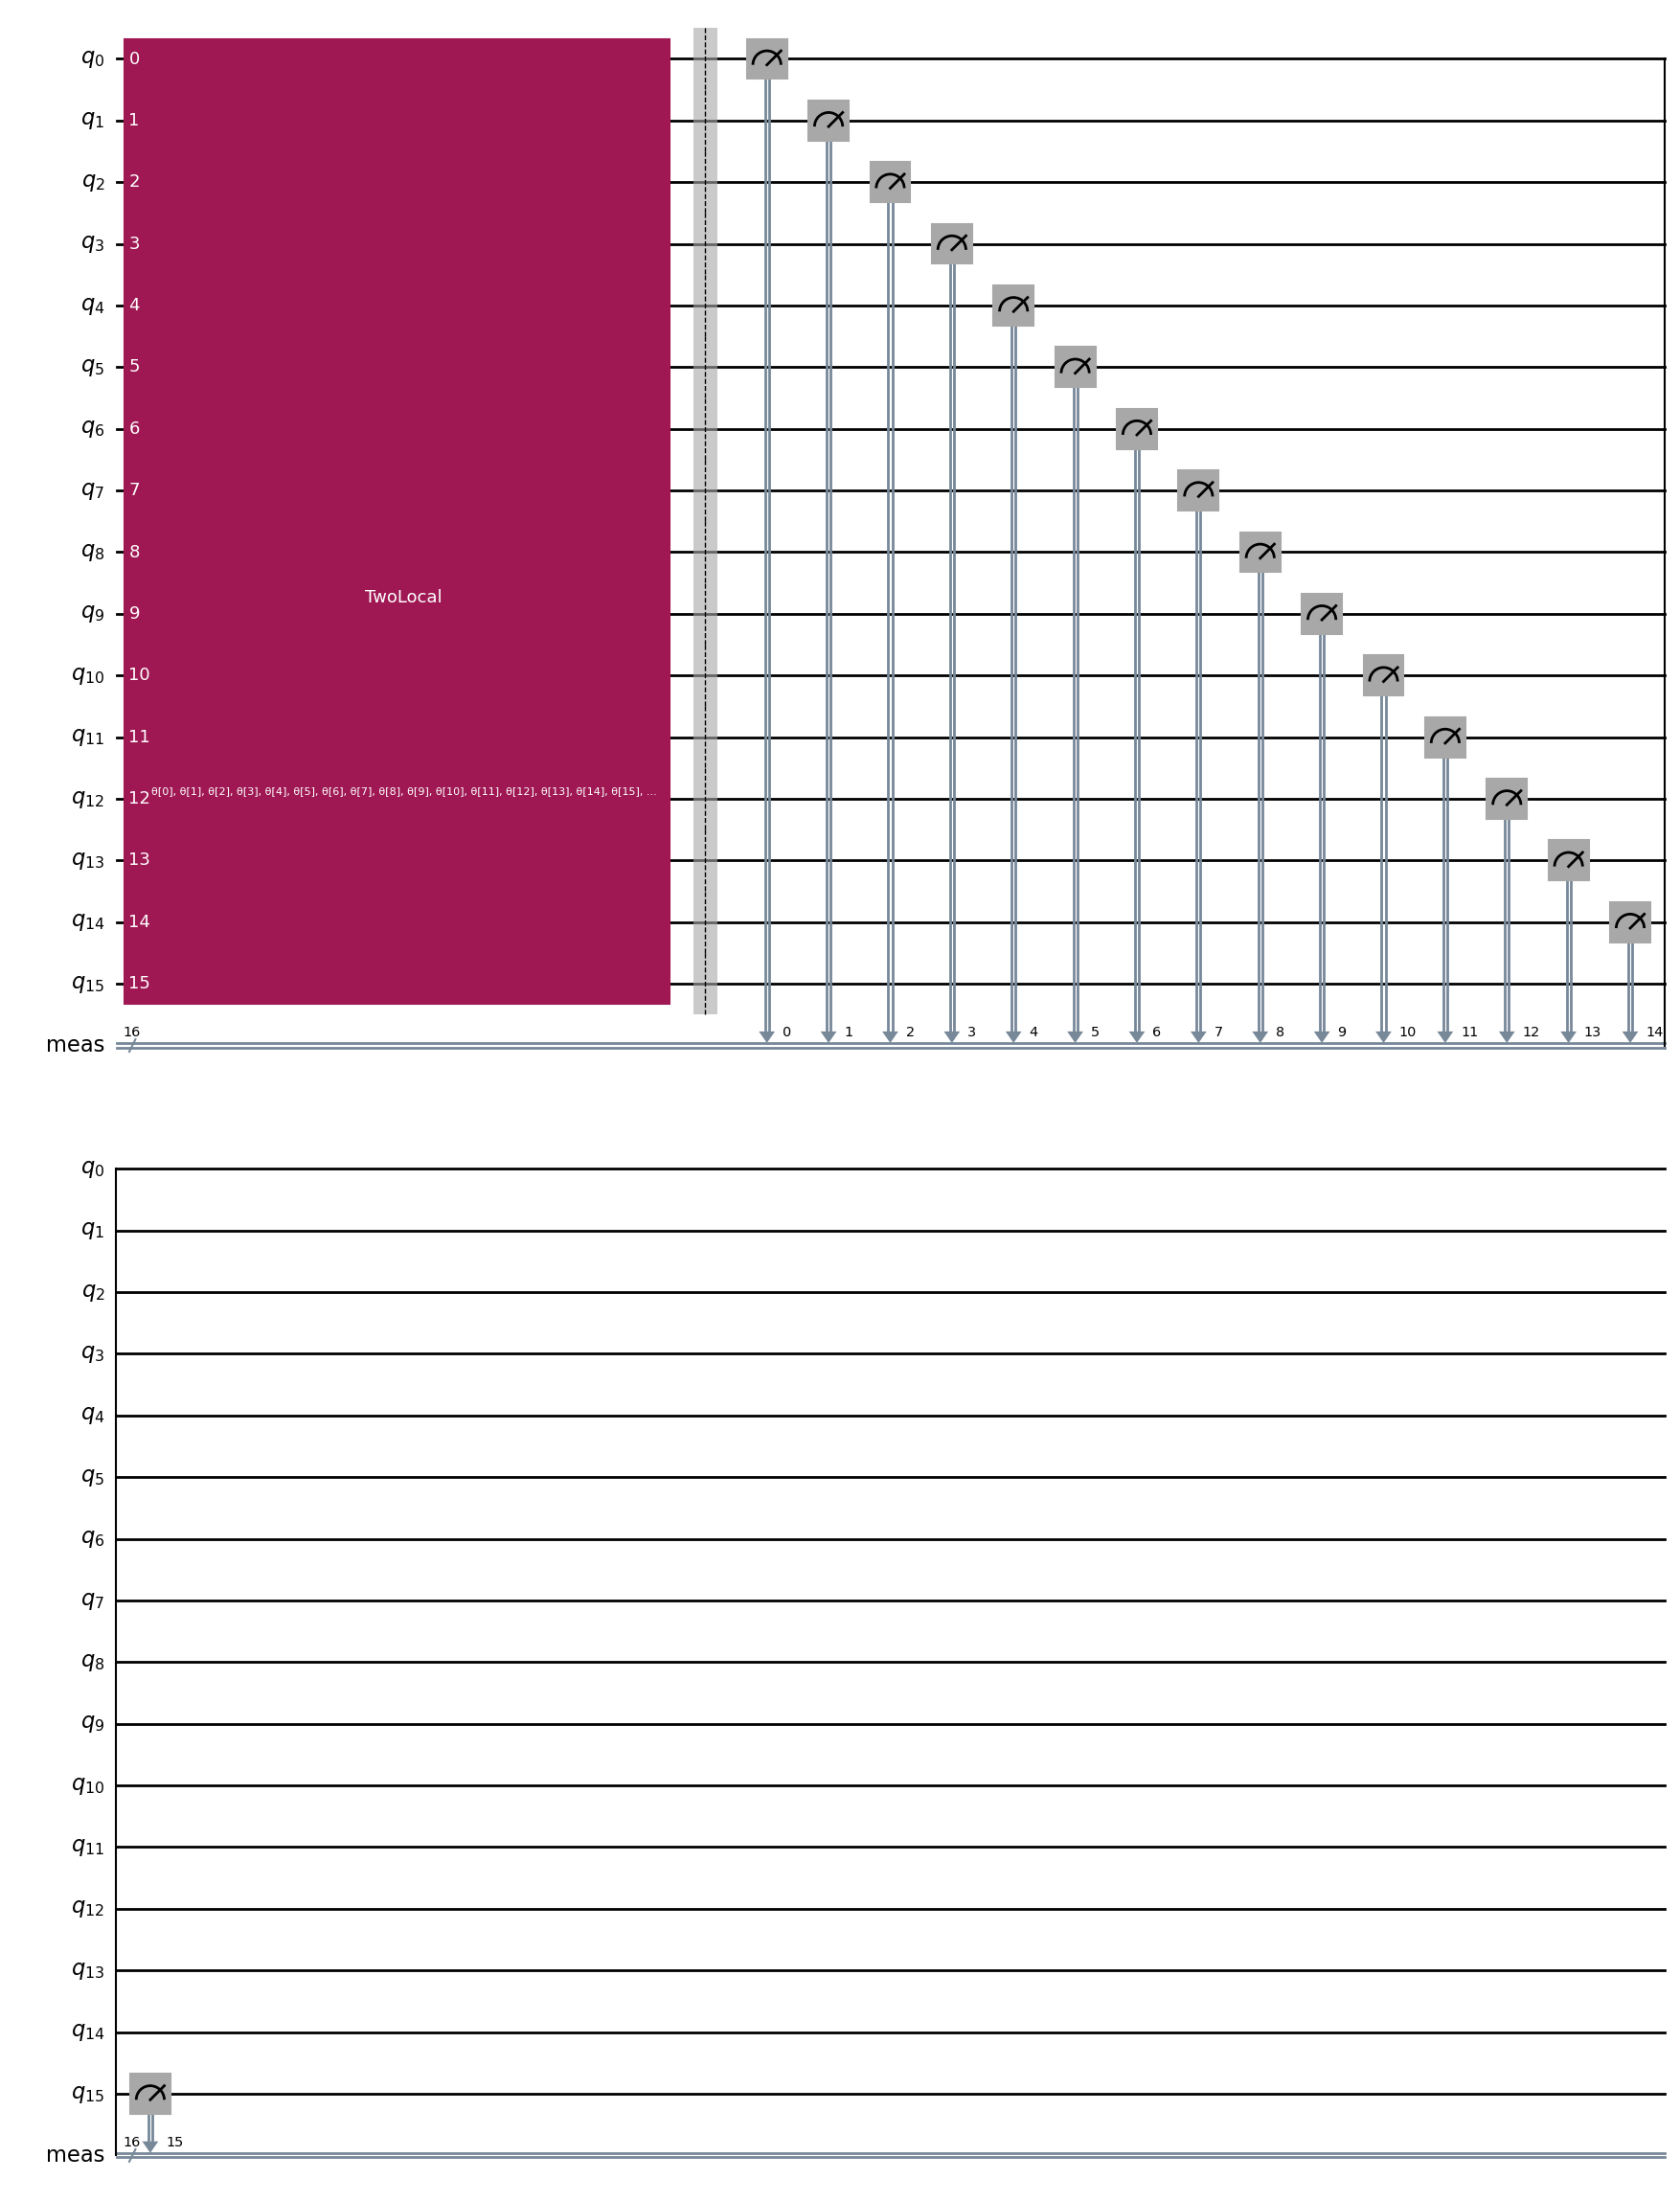

In [18]:
# Create QAOA Circuit from Hamiltonian
# ========= Using QAOAA Ansats from Qiskit ========
# qc = QAOAAnsatz(hamiltonian, reps=1)
# qc.measure_all()
# qc.decompose(reps=3).draw(output="mpl", style="iqp")


# ====== Using TWO Local Ansats from Qiskit ========
qc = TwoLocal(hamiltonian.num_qubits, "ry", "rzz", reps=2, entanglement="linear")
init_point = np.random.random(qc.num_parameters)
qc.measure_all()
qc.draw(output="mpl")

# ======= Using Custom Circuit =========
# p=5 # reps or layer
# init_point = 2*np.pi * np.random.random(2*p)
# qc = get_qaoa_circuit(G, init_point[:p], init_point[p:])
# qc.draw(output="mpl")


### Running on Real Hardware both Estimator (getting expectation value) and Sampler(getting Probability Distribution) using Session

In [19]:
init_point = np.random.random(qc.num_parameters)
qc.measure_all()
pm = generate_preset_pass_manager(optimization_level=1, backend=backend)
isa_circuit = pm.run(qc)
isa_observables = hamiltonian.apply_layout(isa_circuit.layout)

with Session(service=service, backend=backend) as session:
    sampler = Sampler(session=session)
    estimator = Estimator(session=session)
    # options=Options()
    # sampler.options.twirling.enable_measure = True
    # sampler.options.dynamical_decoupling.enable = True
    # sampler.options.dynamical_decoupling.sequence_type = "XpXm"
    # sampler.options.update(default_shots=1024)
    job1 = sampler.run([(isa_circuit, init_point)])
    job2 = estimator.run([(isa_circuit, isa_observables, [init_point])])
    # sampling_vqe = SamplingVQE(sampler, qc, optimizer, initial_point=init_point, callback=samplevqe_callback)
    # result_samp = sampling_vqe.compute_minimum_eigenvalue(hamiltonian)
    # vqe = VQE(estimator, qc, optimizer, initial_point=init_point, callback=samplevqe_callback)
    # print(vqe)
    # result_esti = vqe.compute_minimum_eigenvalue(hamiltonian)
    print(f">>> Job ID: {job1.job_id()}")
    print(f">>> Job Status: {job1.status()}")
    result1 = job1.result()
    result2 = job2.result()
    # result_esti = result.metadata()
    session.close()

>>> Job ID: csavqxzkh0e0008w0wtg
>>> Job Status: QUEUED


In [30]:
print("Showing Sampler Probability Distribution result")
result1[0].data.meas.get_counts()

Showing Smapling result


{'0001010011010101': 1,
 '1100001000110101': 1,
 '0011011110100101': 1,
 '0011101001101101': 1,
 '0010000101000000': 4,
 '0000000001010100': 1,
 '0001001011100101': 1,
 '1010110001110100': 1,
 '0000101001100100': 2,
 '0000000001110100': 4,
 '0010110101111101': 1,
 '0000011011100000': 1,
 '0001000011001001': 1,
 '1010000001001100': 1,
 '1000000000100101': 1,
 '0001000110100100': 1,
 '1001000001000100': 2,
 '0011110001011110': 1,
 '0001000001110110': 1,
 '0000011001100001': 2,
 '0011000010010101': 1,
 '1010001000000101': 1,
 '1001001110100101': 1,
 '0110100110110110': 1,
 '0111011010111010': 1,
 '0001000001100100': 1,
 '0000000001001100': 2,
 '0000100001100011': 1,
 '0000101001011101': 1,
 '0000100101110101': 3,
 '0000001100100100': 1,
 '0011000101110101': 4,
 '1000000001110111': 1,
 '0110100001110101': 1,
 '0000000011010110': 1,
 '0001001010100110': 2,
 '0010001101000110': 1,
 '1011001001100100': 1,
 '0010000001000000': 1,
 '1110010111000010': 1,
 '0111000001110111': 1,
 '10000010101000

In [31]:
print("Showing Estimator expectation value")
result2[0].data.evs. # we need eigen state as well currently not available


array([-6954.98827789])

#### Finding valid Output which diagonal should be zero ( no self loop) and sum of column and row should be 1 (exactly one incoming and outgoing)

In sampler output we do see many invalid result like this 1010100101101001 might be due to noise

In [22]:
import numpy as np

# Sample data
counts = result1[0].data.meas.get_counts()

# Initialize a list to store valid matrices
valid_matrices = []

# Calculate the dimension of the matrices
length = len(list(counts.keys())[0])
dimension = int(np.sqrt(length))
print("dimension - ",dimension)
valid_matrices = []

# Calculate the dimension of the matrices
length = len(list(counts.keys())[0])
dimension = int(np.sqrt(length))

for binary_string, count in counts.items():
    # Convert binary string to 2D matrix
    matrix = np.array([int(bit) for bit in binary_string]).reshape(dimension, dimension)

    # Check the sum of rows and columns
    row_sums = matrix.sum(axis=1)
    col_sums = matrix.sum(axis=0)

    # Check if diagonal values are zero
    diagonal_values = np.diag(matrix)

    if np.all(row_sums == 1) and np.all(col_sums == 1) and np.all(diagonal_values == 0):
        valid_matrices.append({
            'matrix': matrix,
            'count': count,
            'valid': True
        })

# Display the valid matrices
for item in valid_matrices:
    print("Matrix:\n", item['matrix'])
    print("Count:", item['count'])
    print("Valid:", item['valid'])
    print()


4
Matrix:
 [[0 0 1 0]
 [0 0 0 1]
 [0 1 0 0]
 [1 0 0 0]]
Count: 1
Valid: True



-------------Problem Graph--------


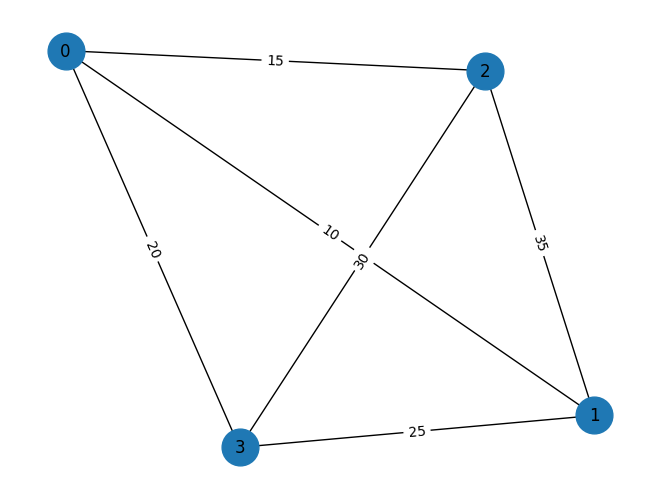

-------------Solution Graph--------


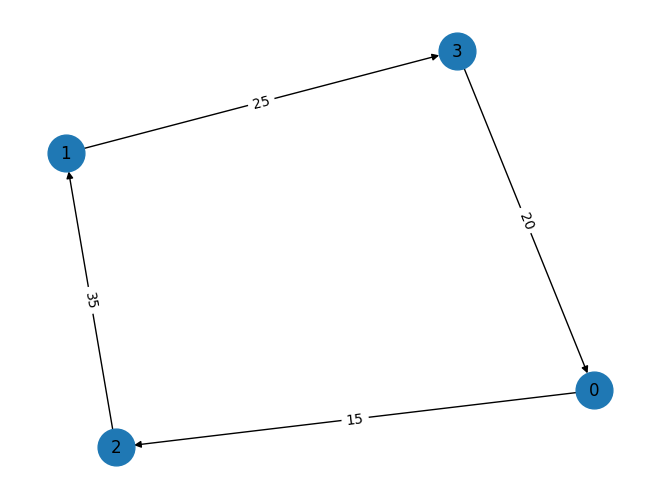

Here is the our result
Matrix:
 [[0 0 1 0]
 [0 0 0 1]
 [0 1 0 0]
 [1 0 0 0]]
Count: 1
Valid: True



In [33]:
# Function to draw the graph with weights from the distance matrix
def draw_graph(matrix, distance_matrix):
    G = nx.DiGraph()  # Directed graph since adjacency matrix can be asymmetric

    # Add nodes
    num_nodes = matrix.shape[0]
    for i in range(num_nodes):
        G.add_node(i)

    # Add edges with weights from the distance matrix
    for i in range(num_nodes):
        for j in range(num_nodes):
            if matrix[i, j] == 1:
                G.add_edge(i, j, weight=distance_matrix[i, j])

    # Draw the graph
    pos = nx.spring_layout(G)  # Layout for better visualization
    nx.draw(G, pos, with_labels=True, node_size=700, font_size=12)

    # Draw edge labels with weights
    edge_labels = {(i, j): G[i][j]['weight'] for i, j in G.edges()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    plt.show()

print("-------------Problem Graph--------")
#Problem Network
pos = nx.spring_layout(G)  # Layout for better visualization
nx.draw(G, pos, with_labels=True, node_size=700, font_size=12)

# Draw edge labels
edge_labels = {(i, j): G[i][j]['weight'] for i, j in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.show()

print("-------------Solution Graph--------")
# Draw the valid matrices as graphs
for item in valid_matrices:
    draw_graph(item['matrix'], distance_matrix)
    print("Here is the our result")
    print("Matrix:\n", item['matrix'])
    print("Count:", item['count'])
    print("Valid:", item['valid'])
    print()

In [29]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    # pub = (ansatz, [hamiltonian], [params])
    # result = estimator.run(pubs=[pub]).result()
    result = estimator.run(circuits=[ansatz], observables=[hamiltonian], parameter_values=[params]).result()
    cost = result.values[0]
    # cost = result[0].data.evs[0]

    return cost

In [ ]:
# To run on local simulator:
#   1. Use the StatevectorEstimator from qiskit.primitives instead.
#   2. Remove the Session instantiation below.
# session = Session(backend=backend)

# # Configure estimator
# estimator = Estimator(session=session)
# options=Options()
# estimator.options.default_shots = 10_000
# # estimator.options.update(default_shots=4096, dynamical_decoupling={"sequence_type": "XY4"})

# # Configure sampler
# sampler = Sampler(session=session)
# sampler.options.default_shots = 10_000
# sampler.options.dynamical_decoupling.enable = True



# x0 = 2 * np.pi * np.random.rand(isa_circuit.num_parameters)


# res = minimize(cost_func, x0, args=(isa_circuit, hamiltonian_isa, estimator), method="COBYLA")
# res



with Session(service=service, backend=backend) as session:
    # Configure Estimator within the session
    estimator = Estimator(session=session)
    estimator.options.default_shots = 1024
    # Configure Sampler within the session
    sampler = Sampler(session=session)
    sampler.options.default_shots = 1000
    # sampler.options.dynamical_decoupling.enable = True
    job = estimator.run(circuits=[isa_circuit], observables=[hamiltonian_isa], parameter_values=[params]).result()
    pub = (qc, [hamiltonian], [params])
    result = sampler.run(pubs=[pub]).result()
    cost = result[0].data.evs[0]
    print(f">>> Job ID: {job.job_id()}")
    print(f">>> Job Status: {job.status()}")
    result = job.result()
    session.close()

    # x0 = 2 * np.pi * np.random.rand(isa_circuit.num_parameters)
    # Optimize the cost function
    # print(f">>> Job ID: {job.job_id()}")
    # print(f">>> Job Status: {job.status()}")
    # res = minimize(cost_func, x0, args=(isa_circuit, hamiltonian_isa, estimator), method="COBYLA")
    # print(res)



# with Session(service=service, backend=backend) as session:
#     sampler = Sampler(session=session)
#     options=Options()
#     smapler = Sampler()
#     sampler.options.update(default_shots=4096, dynamical_decoupling={"sequence_type": "XY4"})
#     job = sampler.run([isa_circuit])
#     # job = sampler.run(circuits=[isa_circuit], observables=[hamiltonian_isa], parameter_values=[params]).result()
#     # pub = (qc, [hamiltonian], [params])
#     # result = sampler.run(pubs=[pub]).result()
#     # cost = result[0].data.evs[0]
#     print(f">>> Job ID: {job.job_id()}")
#     print(f">>> Job Status: {job.status()}")
#     result = job.result()
#     session.close()

<ipython-input-30-df9f2d35a387>:29: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(session=session)


In [ ]:
with Session(service=service, backend=backend) as session:
    sampler = Sampler(session=session)
    options=Options()
    smapler = Sampler()
    sampler.options.update(default_shots=4096, dynamical_decoupling={"sequence_type": "XY4"})
    job = sampler.run([isa_circuit])

    pub = (qc, [hamiltonian], [params])
    result = sampler.run(pubs=[pub]).result()
    cost = result[0].data.evs[0]


    print(f">>> Job ID: {job.job_id()}")
    print(f">>> Job Status: {job.status()}")
    result = job.result()
    session.close()

NameError: name 'backend' is not defined